# ------------------------------------------------------------
# Unsupervised chart-pattern discovery with TS2Vec + DBSCAN
# ------------------------------------------------------------

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math, torch                            # added math

from ts2vec import TS2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


# ─────────────────────────────────────────────────────────────
# 1  Helper functions
# ─────────────────────────────────────────────────────────────

In [3]:
def make_windows(series, size=256, stride=1):
    """Slice a 1-D NumPy array into overlapping windows."""
    series = np.asarray(series, dtype=np.float32)
    n = (len(series) - size) // stride + 1
    return np.stack([series[i*stride : i*stride + size] for i in range(n)])

def plot_candle(window, *, ax=None, up="#28a745", dn="#e83e8c"):
    """Line plot for 1-D prototypes or OHLC candlesticks for 4-channel data."""
    win = np.asarray(window)
    created = ax is None
    if created:
        fig, ax = plt.subplots(figsize=(6, 3))

    if win.ndim == 1:                          # Close-only
        ax.plot(win, lw=1.5)
    elif win.shape[0] >= 4:                    # OHLC
        o, h, l, c = win[:4]
        for i in range(len(o)):
            col = up if c[i] >= o[i] else dn
            ax.vlines(i, l[i], h[i], color=col, lw=0.8)
            body_low, body_high = sorted([o[i], c[i]])
            ax.add_patch(Rectangle((i-0.3, body_low), 0.6,
                                   max(body_high-body_low, 1e-3),
                                   color=col))
        ax.set_xlim(-1, len(o))
    else:
        raise ValueError("window must be 1-D or (4, T) OHLC")

    ax.grid(ls="--", alpha=.2)
    if created:
        plt.tight_layout(); plt.show()

# ─────────────────────────────────────────────────────────────
# 2  Load data & build windows
# ─────────────────────────────────────────────────────────────

In [ ]:
df = yf.download("AAPL", start="2018-01-01", end="2025-01-01")
close   = df["Close"].values
windows = make_windows(close, size=256, stride=1)
print(f"{windows.shape[0]:,} windows of length 256")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1,506 windows of length 256


# ─────────────────────────────────────────────────────────────
# 3  Self-supervised embedding with TS2Vec
# ─────────────────────────────────────────────────────────────

In [6]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
encoder = TS2Vec(input_dims=1, device=device)
encoder.fit(windows, verbose=True)

Z = encoder.encode(windows).mean(axis=1)       # (N, d) for sklearn

Epoch #0: loss=4631.762067186071
Epoch #1: loss=51.83261317395149
Epoch #2: loss=28.12583177647692
Epoch #3: loss=14.615497518093028
Epoch #4: loss=10.715291540673439
Epoch #5: loss=9.425474577761712


# ─────────────────────────────────────────────────────────────
# 4  Cluster embeddings with DBSCAN
# ─────────────────────────────────────────────────────────────

In [24]:
Z_scaled = StandardScaler().fit_transform(Z)
labels   = DBSCAN(eps=0.6, min_samples=10).fit_predict(Z_scaled)
dist     = dict(zip(*np.unique(labels, return_counts=True)))
print("Cluster distribution:", dist)

Cluster distribution: {np.int64(-1): np.int64(505), np.int64(0): np.int64(398), np.int64(1): np.int64(11), np.int64(2): np.int64(47), np.int64(3): np.int64(43), np.int64(4): np.int64(14), np.int64(5): np.int64(17), np.int64(6): np.int64(42), np.int64(7): np.int64(105), np.int64(8): np.int64(10), np.int64(9): np.int64(29), np.int64(10): np.int64(24), np.int64(11): np.int64(35), np.int64(12): np.int64(21), np.int64(13): np.int64(22), np.int64(14): np.int64(12), np.int64(15): np.int64(20), np.int64(16): np.int64(15), np.int64(17): np.int64(27), np.int64(18): np.int64(10), np.int64(19): np.int64(23), np.int64(20): np.int64(11), np.int64(21): np.int64(24), np.int64(22): np.int64(24), np.int64(23): np.int64(17)}


# ─────────────────────────────────────────────────────────────
# 5  Pattern Gallery  (prototype ± 1 σ per sizeable cluster)
# ─────────────────────────────────────────────────────────────

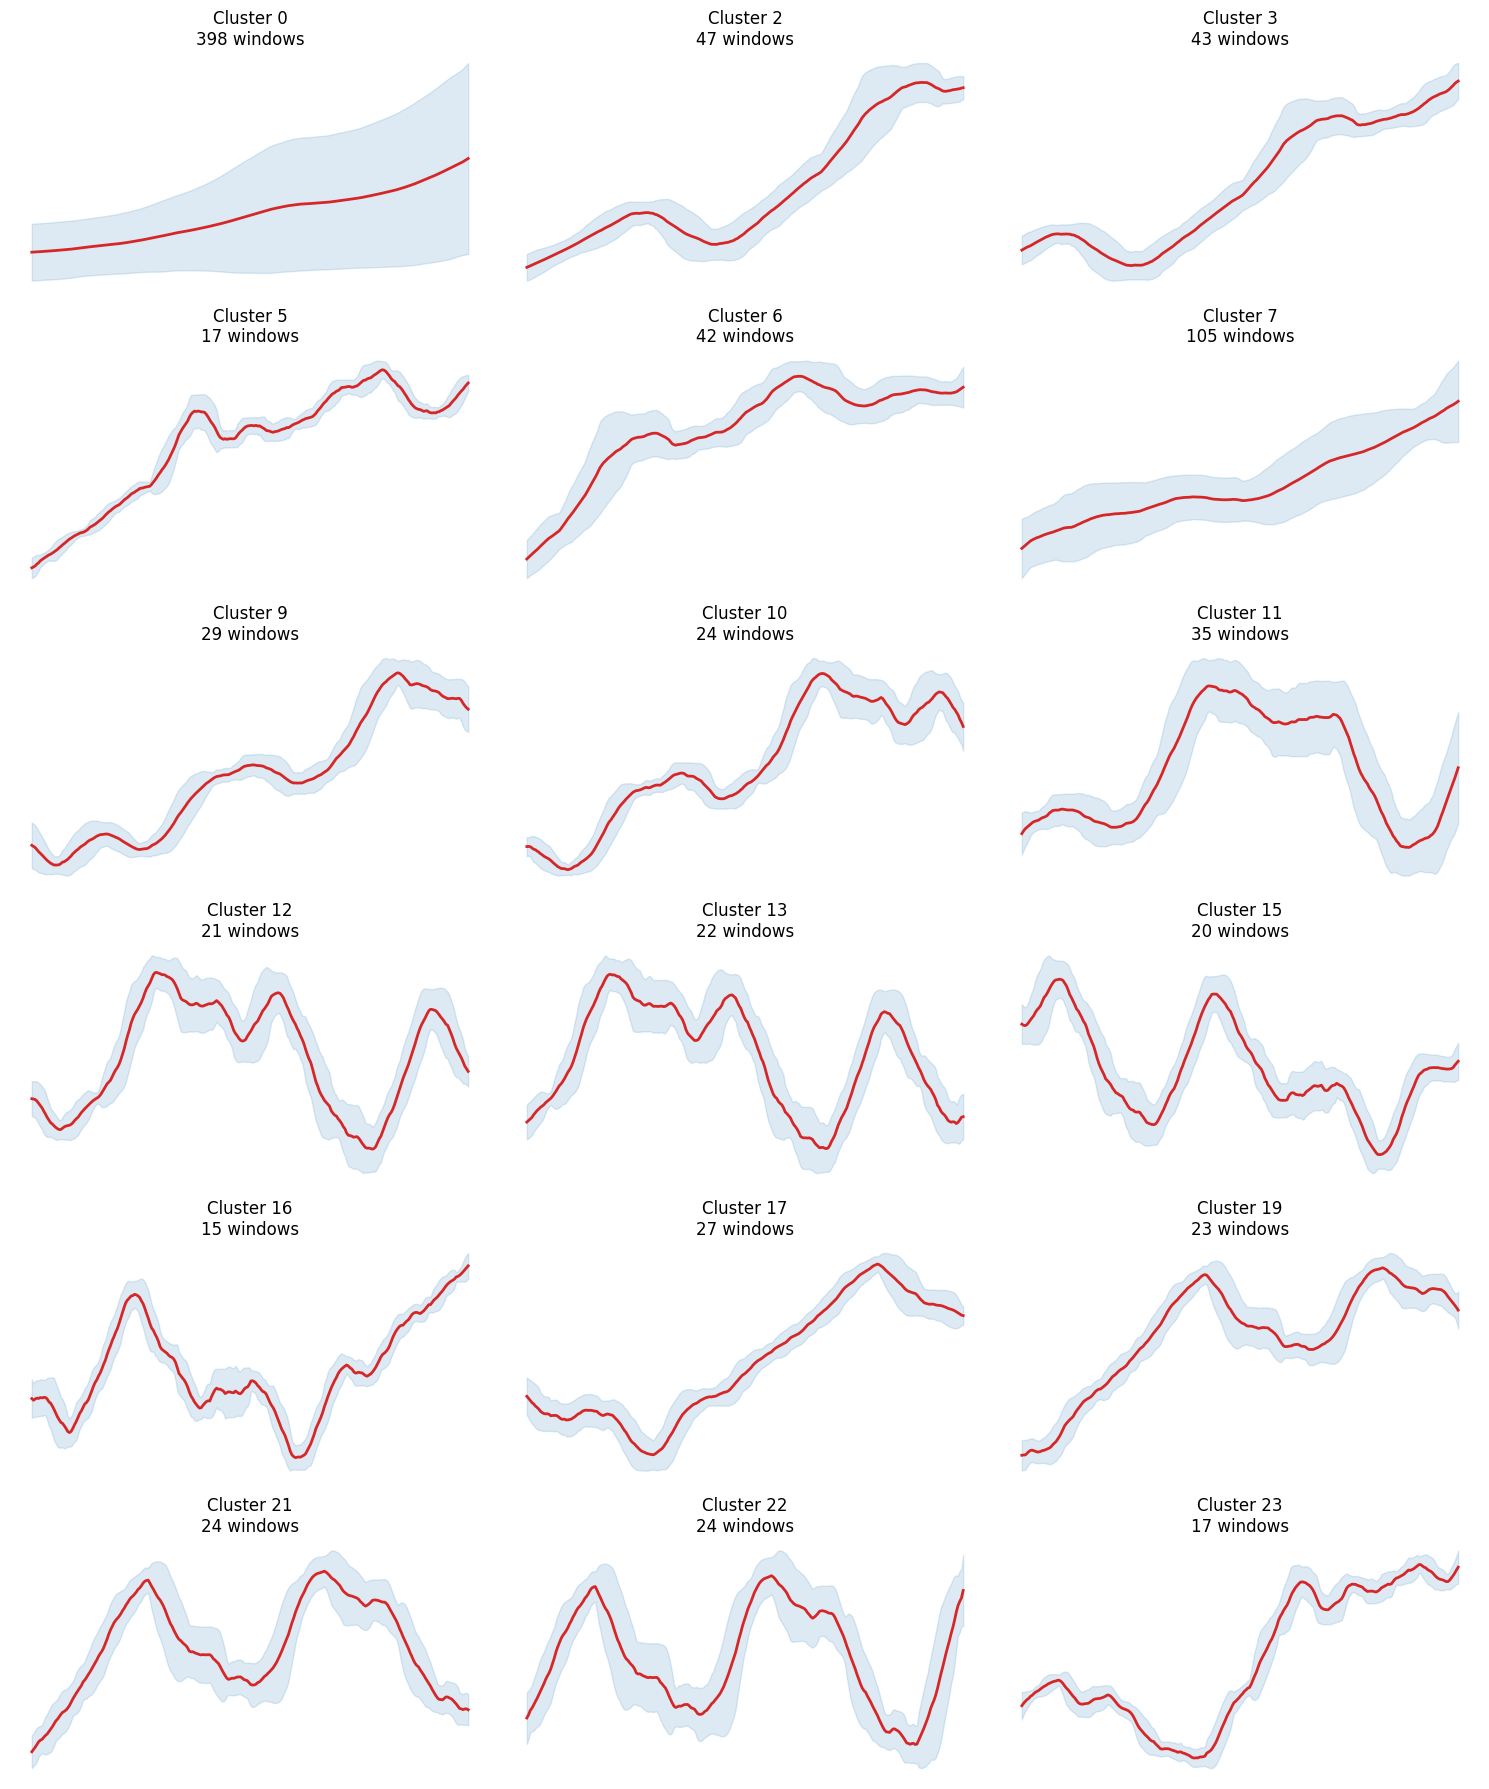

In [25]:
# ─────────────────────────────────────────────────────────────
# Pattern Gallery  (prototype ± 1 σ per sizeable cluster)
# ─────────────────────────────────────────────────────────────
MIN_SIZE = 15
clust_ids = [cid for cid, cnt in dist.items()
             if cid != -1 and cnt >= MIN_SIZE]

if clust_ids:
    cols = 3
    rows = math.ceil(len(clust_ids) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 3*rows),
                            squeeze=False)

    for ax, cid in zip(axs.ravel(), clust_ids):
        members = windows[labels == cid]

        # ✔ NEW CODE — robust prototype/std extraction
        proto = members.mean(0).ravel()          # force 1-D
        std   = members.std(0).ravel()           # force 1-D
        if proto.ndim != 1 or proto.size == 0:   # safety guard
            print(f"Cluster {cid} skipped (bad shape)")
            ax.axis("off")
            continue

        x = np.arange(proto.size)
        ax.fill_between(x, proto - std, proto + std,
                        color="#1f77b4", alpha=.15)
        ax.plot(x, proto, color="#d62728", lw=2)
        ax.set_title(f"Cluster {cid}\n{len(members)} windows")
        ax.axis("off")

    # hide any unused panels
    for ax in axs.ravel()[len(clust_ids):]:
        ax.axis("off")

    plt.tight_layout(); plt.show()
else:
    print(f"No clusters have ≥{MIN_SIZE} windows – nothing to plot.")